
<i>Updated 29/Nov/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />


# Further Training of Cycle Generative Adversarial Network for VidTIMIT dataset with Tensorflow 2 on Google Colab (WGAN-GP)

Assuming that you have already executed CycleGAN_VidTIMIT_Train.ipynb, further train the Model. 

## VidTIMIT データセットに対して Cycle Generative Adversarial Network をGoogle Colab 上の Tensorflow 2 でさらに学習させる

既に CycleGAN_VidTIMIT_Train.ipynb を実行していることを前提とし、さらに学習を進める。





In [1]:
MAX_EPOCHS = 150     # Change this value and run this ipynb many times

save_path = '/content/drive/MyDrive/ColabRun/CycleGAN_VidTIMIT01'
VERBOSE = False

In [2]:
#! pip install tensorflow==2.7.0

In [3]:
! pip install tensorflow_addons

In [4]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

2.7.0


In [5]:
import numpy as np

np.random.seed(2022)

# Check the Google Colab runtime environment

## Google Colab 実行環境を調べる

In [6]:
if VERBOSE:
    ! nvidia-smi
    ! cat /proc/cpuinfo
    ! cat /etc/issue
    ! free -h

# Mount Google Drive from Google Colab

## Google Colab から GoogleDrive をマウントする

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
if VERBOSE:
    ! ls /content/drive

# Download source file from Google Drive or nw.tsuda.ac.jp

Basically, <code>gdown</code> from Google Drive.
Download from nw.tsuda.ac.jp above only if the specifications of Google Drive change and you cannot download from Google Drive.

# Google Drive または nw.tsuda.ac.jp からファイルをダウンロードする

基本的に、Google Drive から <code>gdown</code> してください。
Google Drive の仕様が変わってダウンロードができない場合にのみ、nw.tsuda.ac.jp からダウンロードしてください。

In [9]:
# Download source file
nw_path = './nw'
! rm -rf {nw_path}
! mkdir -p {nw_path}

if True:   # from Google Drive
    url_model =  'https://drive.google.com/uc?id=1aNvpPDNeDWYQFu_PA1kOtFlzcO5seHky'
    ! (cd {nw_path}; gdown {url_model})
else:      # from nw.tsuda.ac.jp
    URL_NW = 'https://nw.tsuda.ac.jp/lec/GoogleColab/pub'
    url_model = f'{URL_NW}/models/CycleGAN.py'
    ! wget -nd {url_model} -P {nw_path}

Downloading...
From: https://drive.google.com/uc?id=1aNvpPDNeDWYQFu_PA1kOtFlzcO5seHky
To: /content/nw/CycleGAN.py
100% 24.6k/24.6k [00:00<00:00, 21.4MB/s]


In [10]:
if VERBOSE:
    ! cat {nw_path}/CycleGAN.py

# Preparing VidTIMIT dataset

Official WWW of VidTIMIT dataset: http://conradsanderson.id.au/vidtimit/

zip files of 2 persons of VidTIMIT dataset: <br />
https://zenodo.org/record/158963/files/fadg0.zip  <br />
https://zenodo.org/record/158963/files/faks0.zip  <br />

zip files mirrored on my Google Drive: <br />
https://drive.google.com/uc?id=

## VidTIMIT データセットを用意する

VidTIMIT データセットの公式ページ: http://conradsanderson.id.au/vidtimit/

VidTIMIT の2名の顔写真の zip ファイル: <br />
https://zenodo.org/record/158963/files/fadg0.zip <br />
https://zenodo.org/record/158963/files/faks0.zip <br />


自分の Google Drive 上にミラーした顔写真: <br />
https://drive.google.com/uc?id=
https://drive.google.com/uc?id=



In [11]:
# Download zip files
VidTIMIT_site = 'https://zenodo.org/record/158963/files/'
VidTIMIT_fnames = [ 'fadg0', 'faks0']

Mirrored_files = [
    'https://drive.google.com/uc?id=1_Fv4p9MDNphMZMnLpEvtCtnwXgN8N5Cj', 
    'https://drive.google.com/uc?id=1Y8j7ThPVqB0gbx4hb9aMEp9Ptr9wFuoz'
]

data_dir = './datasets'
! rm -rf $data_dir
! mkdir -p $data_dir

for i, fname in enumerate(VidTIMIT_fnames):
    fzip = fname + '.zip'
    if False:
        url = VidTIMIT_site + fzip
        !wget {url}
    else:
        url = Mirrored_files[i]
        !gdown {url}

    !unzip -q {fzip} -d {data_dir}

Downloading...
From: https://drive.google.com/uc?id=1_Fv4p9MDNphMZMnLpEvtCtnwXgN8N5Cj
To: /content/fadg0.zip
100% 81.6M/81.6M [00:00<00:00, 260MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y8j7ThPVqB0gbx4hb9aMEp9Ptr9wFuoz
To: /content/faks0.zip
100% 64.2M/64.2M [00:00<00:00, 201MB/s]


# Make DataGenerator from the images of VidTIMIT

## VidTIMIT の画像ファイルから DataGenerator を作る

In [12]:
IMAGE_SIZE = 128

In [13]:
import os
import glob

imgA_paths = glob.glob(os.path.join(data_dir, VidTIMIT_fnames[0], 'video/*/[0-9]*'))
imgB_paths = glob.glob(os.path.join(data_dir, VidTIMIT_fnames[1], 'video/*/[0-9]*'))

In [14]:
import numpy as np

validation_split = 0.05

nA, nB = len(imgA_paths), len(imgB_paths)
splitA = int(nA * (1 - validation_split))
splitB = int(nB * (1 - validation_split))

np.random.shuffle(imgA_paths)
np.random.shuffle(imgB_paths)

train_imgA_paths = imgA_paths[:splitA]
test_imgA_paths = imgA_paths[splitA:]
train_imgB_paths = imgB_paths[:splitB]
test_imgB_paths = imgB_paths[splitB:]

In [15]:
# Image: [-1, 1] --> [0, 1]
def M1P1_ZeroP1(imgs):
    imgs = (imgs + 1) * 0.5
    return np.clip(imgs, 0, 1)

# Image: [0, 1] --> [-1, 1]
def ZeroP1_M1P1(imgs):
    return imgs * 2 - 1

In [16]:
from nw.CycleGAN import PairDataset

pair_flow = PairDataset(train_imgA_paths, train_imgB_paths, target_size=(IMAGE_SIZE, IMAGE_SIZE))
test_pair_flow = PairDataset(test_imgA_paths, test_imgB_paths, target_size=(IMAGE_SIZE, IMAGE_SIZE))

# Define the Neural Network Model

## ニューラルネットワーク・モデルを定義する

In [17]:
from nw.CycleGAN import CycleGAN

gan = CycleGAN.load(save_path)

print(gan.epoch)

5


# Train

## 訓練する

# Further Training

# さらに学習を進める

In [18]:
gan.train(
    pair_flow,
    epochs = MAX_EPOCHS,
    batch_size=1,
    run_folder = save_path,
    print_step_interval = 1000,
    save_epoch_interval = 50
)

Epoch 6/150 1000/2595 [D loss: 0.062 acc: 1.000][G loss: 2.184 adv: 1.268 recon: 0.076 id: 0.076 time: 0:03:13.098820
Epoch 6/150 2000/2595 [D loss: 0.095 acc: 0.863][G loss: 2.319 adv: 1.147 recon: 0.098 id: 0.094 time: 0:06:14.734277
Epoch 6/150 [D loss: 0.079 acc: 0.927][G loss: 1.962 adv: 1.003 recon: 0.080 id: 0.079 time: 0:08:02.714840
Epoch 7/150 1000/2595 [D loss: 0.043 acc: 0.984][G loss: 2.668 adv: 1.744 recon: 0.077 id: 0.076 time: 0:11:03.594376
Epoch 7/150 2000/2595 [D loss: 0.034 acc: 0.995][G loss: 1.695 adv: 0.578 recon: 0.093 id: 0.092 time: 0:14:06.746020
Epoch 7/150 [D loss: 0.073 acc: 0.935][G loss: 2.009 adv: 1.061 recon: 0.079 id: 0.078 time: 0:15:55.227086
Epoch 8/150 1000/2595 [D loss: 0.060 acc: 0.981][G loss: 2.155 adv: 1.214 recon: 0.079 id: 0.078 time: 0:18:58.266541
Epoch 8/150 2000/2595 [D loss: 0.104 acc: 0.935][G loss: 3.006 adv: 1.872 recon: 0.094 id: 0.095 time: 0:22:02.163284
Epoch 8/150 [D loss: 0.075 acc: 0.934][G loss: 2.003 adv: 1.068 recon: 0.078

In [19]:
! ls {save_path}/weights

combined-weights_100.h5  d_A-weights_5.h5     g_AB-weights_3.h5
combined-weights_150.h5  d_A-weights.h5       g_AB-weights_50.h5
combined-weights_1.h5	 d_B-weights_100.h5   g_AB-weights_5.h5
combined-weights_3.h5	 d_B-weights_150.h5   g_AB-weights.h5
combined-weights_50.h5	 d_B-weights_1.h5     g_BA-weights_100.h5
combined-weights_5.h5	 d_B-weights_3.h5     g_BA-weights_150.h5
combined-weights.h5	 d_B-weights_50.h5    g_BA-weights_1.h5
d_A-weights_100.h5	 d_B-weights_5.h5     g_BA-weights_3.h5
d_A-weights_150.h5	 d_B-weights.h5       g_BA-weights_50.h5
d_A-weights_1.h5	 g_AB-weights_100.h5  g_BA-weights_5.h5
d_A-weights_3.h5	 g_AB-weights_150.h5  g_BA-weights.h5
d_A-weights_50.h5	 g_AB-weights_1.h5


# Generate Images

## 画像を生成する

In [20]:
# Display images
# 画像を表示する。
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showImages(imgs, rows=-1, cols=-1, w=2, h=2):
    N = len(imgs)
    if rows < 0: rows = 1
    if cols < 0: cols = (N + rows -1) // rows
    fig, ax = plt.subplots(rows, cols, figsize=(w*cols, h*rows))
    idx = 0
    for row in range(rows):
        for col in range(cols) :
            if rows == 1 and cols == 1:
                axis = ax
            elif rows == 1:
                axis = ax[col]
            elif cols == 1:
                axis = ax[row]
            else:
                axis = ax[row][col]

            if idx < N:
                axis.imshow(imgs[idx])
            axis.axis('off')
            idx += 1
    plt.show()

A-->B-->A, ID


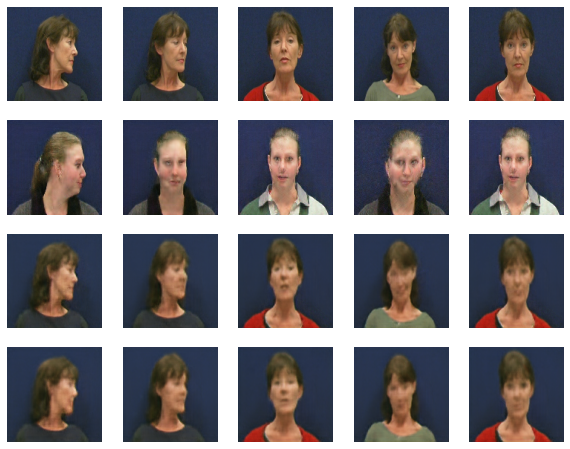

B-->A-->B, ID


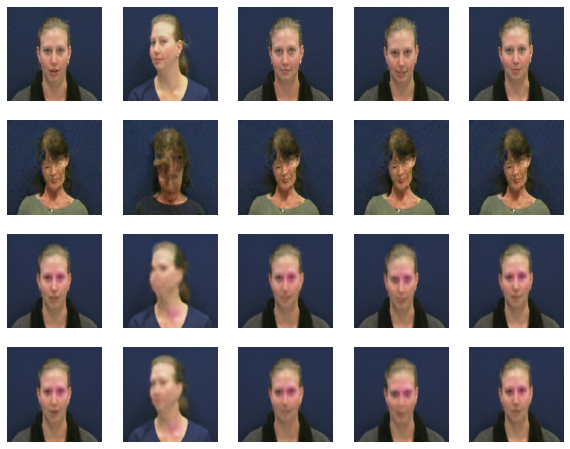

In [21]:
# Display generated and cycle images.
# 生成画像とサイクル画像を表示する。

test_pairs = test_pair_flow[:5]

test_imgsA = test_pairs[:,0]
test_imgsB = test_pairs[:,1]

imgsAB = gan.generate_image_from_A(test_imgsA)
imgsBA = gan.generate_image_from_B(test_imgsB)

print('A-->B-->A, ID')
showImages(M1P1_ZeroP1(imgsAB), 4)

print('B-->A-->B, ID')
showImages(M1P1_ZeroP1(imgsBA), 4)

# Check the loss and accuracy of the training process.

## 学習過程のlossと精度を確認する

loss AB


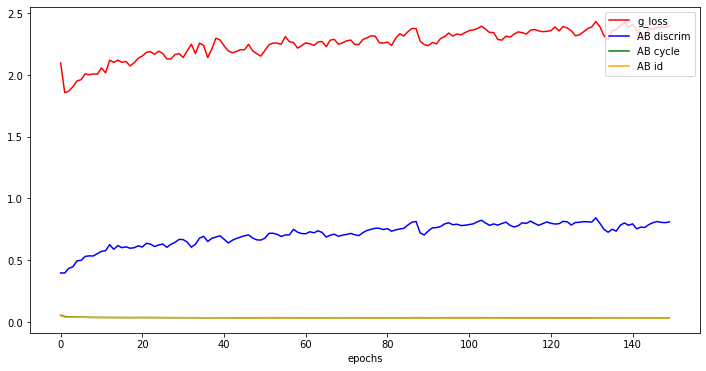

loss BA


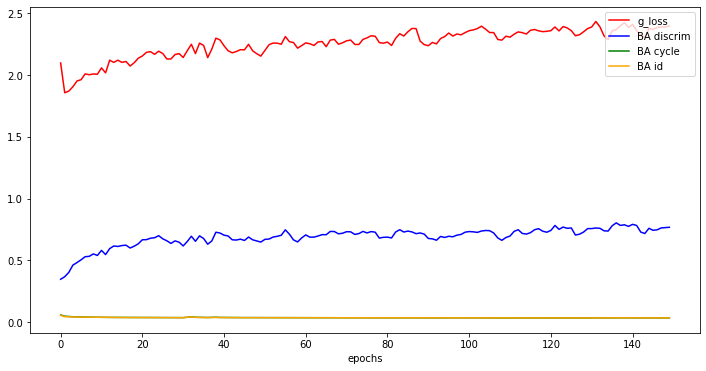

In [22]:
# Display the graph of losses in training
%matplotlib inline

gan.showLoss()

# Check the saved files

## 保存されているファイルを確認する

In [23]:
! ls -lR {save_path}

/content/drive/MyDrive/ColabRun/CycleGAN_VidTIMIT01:
total 128
-rw------- 1 root root 27155 Nov 30 02:00 params_100.pkl
-rw------- 1 root root 40955 Nov 30 08:35 params_150.pkl
-rw------- 1 root root   413 Nov 29 12:52 params_1.pkl
-rw------- 1 root root   895 Nov 29 13:08 params_3.pkl
-rw------- 1 root root 13355 Nov 29 19:32 params_50.pkl
-rw------- 1 root root  1416 Nov 29 13:25 params_5.pkl
-rw------- 1 root root 40955 Nov 30 08:35 params.pkl
drwx------ 2 root root  4096 Nov 30 08:35 weights

/content/drive/MyDrive/ColabRun/CycleGAN_VidTIMIT01/weights:
total 246442
-rw------- 1 root root 17974272 Nov 30 02:00 combined-weights_100.h5
-rw------- 1 root root 17974272 Nov 30 08:35 combined-weights_150.h5
-rw------- 1 root root 17974272 Nov 29 12:52 combined-weights_1.h5
-rw------- 1 root root 17974272 Nov 29 13:08 combined-weights_3.h5
-rw------- 1 root root 17974272 Nov 29 19:32 combined-weights_50.h5
-rw------- 1 root root 17974272 Nov 29 13:25 combined-weights_5.h5
-rw------- 1 root